In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from torchvision import transforms
import seaborn as sns
from PIL import Image


In [11]:
filtered_ds = pd.read_csv("filtered_ds.csv")

# Assuming your dataset class is named CustomDataset
import torch
from torch.utils.data import Dataset
from torchvision import transforms
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.tensor_transform = transforms.ToTensor()

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        pixels = np.fromstring(self.dataframe.iloc[idx]['pixels'][1:-1], sep=' ', dtype=int)
        pixels = pixels.reshape((48, 48)).astype('uint8')

        emotion = int(self.dataframe.iloc[idx]['emotion'])
        pixel_density = float(self.dataframe.iloc[idx]['pixel_density'])

        image = Image.fromarray(pixels)

        if self.transform:
            image = self.transform(image)
        else:
            image = self.tensor_transform(pixels)

        return image, emotion


# Assuming you have a function for data augmentation
transform = transforms.Compose([
    # Add your transformations for data augmentation here if needed
    transforms.ToTensor(),# Convert to PIL Image before ToTensor
])

# Define your dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = CustomDataset(dataframe=filtered_ds, transform=transform)


# Split the dataset into training, validation, and test sets
train_data, test_data = train_test_split(filtered_ds, test_size=0.3, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)


# Define data loaders for training, validation, and test sets
batch_size = 64  # You can adjust this based on your available resources
# Create DataLoader instances for each set
train_loader = DataLoader(CustomDataset(train_data, transform=transform), batch_size=64, shuffle=True)
val_loader = DataLoader(CustomDataset(val_data, transform=transform), batch_size=64, shuffle=False)
test_loader = DataLoader(CustomDataset(test_data, transform=transform), batch_size=64, shuffle=False)


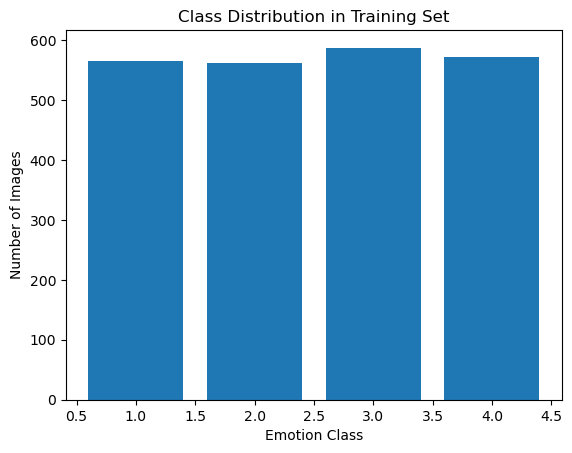

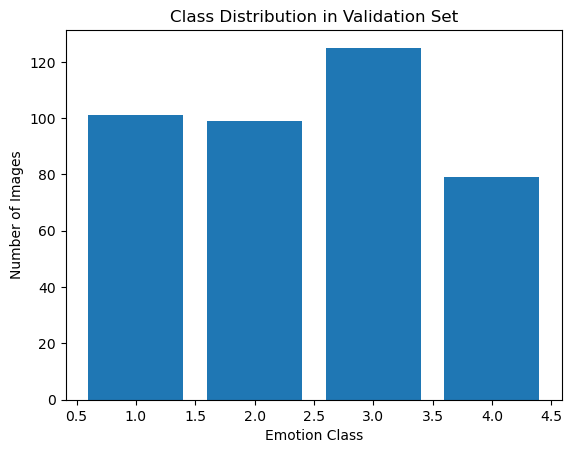

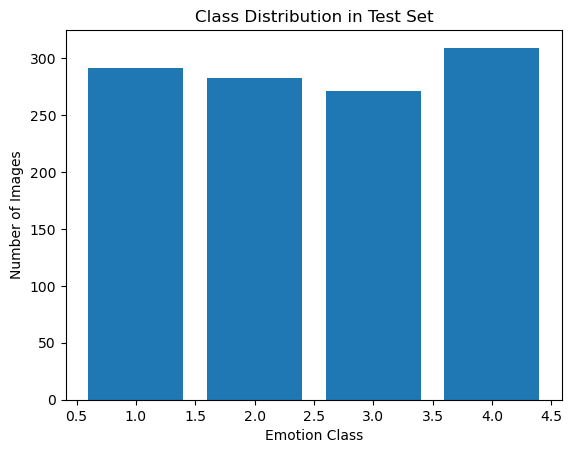

In [12]:
import matplotlib.pyplot as plt

# Function to plot class distribution
def plot_class_distribution(loader, name):
    emotions_count = {1: 0, 2: 0, 3: 0, 4: 0}  # Assuming your classes are 1, 2, 3, 4
    for _, labels in loader:
        for label in labels:
            emotions_count[label.item()] += 1

    plt.bar(emotions_count.keys(), emotions_count.values())
    plt.title(f"Class Distribution in {name} Set")
    plt.xlabel("Emotion Class")
    plt.ylabel("Number of Images")
    plt.show()

# Plot distribution for each set
plot_class_distribution(train_loader, "Training")
plot_class_distribution(val_loader, "Validation")
plot_class_distribution(test_loader, "Test")


In [13]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 4)  # Assuming 4 classes (1, 2, 3, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create an instance of the SimpleCNN model
model = SimpleCNN()


In [14]:
import torch.optim as optim

# Define loss function, optimizer, and other necessary parameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can experiment with the learning rate

# Train your model using a loop over epochs
num_epochs = 15  # You can experiment with the number of epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        # Subtract 1 from labels to make them start from 0
        labels -= 1
        
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

print('Finished Training')
import os
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

# Example usage:
directory_path = './weights'
create_directory(directory_path)

torch.save(model.state_dict(), 'weights/model_weights.pth')


Epoch 1, Loss: 0.8450818624761369
Epoch 2, Loss: 0.5863918604122268
Epoch 3, Loss: 0.4815504352251689
Epoch 4, Loss: 0.41058966765801114
Epoch 5, Loss: 0.3686288930475712
Epoch 6, Loss: 0.32277341766489875
Epoch 7, Loss: 0.28582196434338886
Epoch 8, Loss: 0.265677565915717
Epoch 9, Loss: 0.2520751936568154
Epoch 10, Loss: 0.20355691036416423
Epoch 11, Loss: 0.18721128441393375
Epoch 12, Loss: 0.1670027021318674
Epoch 13, Loss: 0.13389341057174736
Epoch 14, Loss: 0.1213645465258095
Epoch 15, Loss: 0.14632551992932954
Finished Training


In [15]:
# Load the trained weights into the model (replace 'path/to/your/model_weights.pth' with the actual path)
model.load_state_dict(torch.load('weights/model_weights.pth', map_location=torch.device('cpu')))
torch.save(model.state_dict(), 'SimpleCNN_model.pth')

In [27]:
def load_model(model_path):
    model = SimpleCNN()  # Instantiate your model class
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # Load model weights
    model.eval()  # Set the model to evaluation mode
    return model

def preprocess_image(image_path):
    # Add any necessary image preprocessing steps here
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = np.array(img)  # Convert to NumPy array
    # Add additional preprocessing steps if needed
    return img
def predict(model, input_image):
    # Assuming your model takes a NumPy array as input
    input_tensor = torch.FloatTensor(input_image).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    output = model(input_tensor)
    probabilities = F.softmax(output, dim=1)  # Apply softmax along the class dimension

    # Get the predicted class (class with the highest probability)
    _, predicted_class = torch.max(probabilities, 1)

    return predicted_class.item(), probabilities

if __name__ == "__main__":
    model_path = 'SimpleCNN_model.pth'
    input_image_path = 'sample_10.png'  # Provide the path to the input image

    # Load the model
    SimpleCNN_model = load_model(model_path)

    # Preprocess the input image
    input_image = preprocess_image(input_image_path)

    # Make a prediction
    predicted_class, probabilities = predict(SimpleCNN_model, input_image)

    print("Predicted Class:", predicted_class+1)
    print("Class Probabilities:", probabilities)

Predicted Class: 2
Class Probabilities: tensor([[0., 1., 0., 0.]], grad_fn=<SoftmaxBackward0>)


In [23]:
pwd

'/Users/antasjain/Documents/Learnings and other docs/COMP 6721 Project/Python project'